## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

import math

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.rand(4, 5)
y = torch.rand(4, 5)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [3]:
z = torch.empty(4, 5)
torch.mul(x, y, out=z)
z

tensor([[0.4357, 0.0395, 0.3623, 0.0337, 0.1157],
        [0.2110, 0.0527, 0.0755, 0.0495, 0.0568],
        [0.3947, 0.1399, 0.4843, 0.0305, 0.1105],
        [0.0090, 0.2644, 0.9724, 0.2174, 0.0798]])

**Task**: Реализуйте ReLU используя только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [4]:
def relu_forward(x):
    def func(x):
        if x < 0:
            return 0
        else:
            return x
    
    return x.apply_(func)
    

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [5]:
def elu_forward(x, alpha):
    def func(x, alpha):
        if x < 0:
            return alpha * (exp(x) - 1)
        else:
            return x
    
    return x.apply_(lambda x: func(x, alpha))
    

assert torch.allclose(
    F.elu(x, 0.01),
    elu_forward(x, 0.01), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [6]:
def lrelu_forward(x):
    def func(x):
        if x < 0:
            return 0.01 * x
        else:
            return x
    
    return x.apply_(func)

assert torch.all(F.leaky_relu(x) == lrelu_forward(x))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [7]:
def mish(x):
    def func(x):
        return x * math.tanh(math.log(1 + math.exp(x)))
    
    return x.apply_(func)

In [8]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [9]:
def swish(x):
    def func(x):
        return x / (1 + math.exp(-x))
    
    return x.apply_(func)

In [10]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [11]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [12]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        for param in filter(lambda x: x.grad is not None, group['params']):
            pass

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        pass

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        pass

**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [13]:
weights = # your code here
intercept = # your code here

SyntaxError: invalid syntax (<ipython-input-13-3f6fd89247ec>, line 1)

In [14]:
optimizer = Adam([weights, intercept])
loss = nn.CrossEntropyLoss()

NameError: name 'weights' is not defined

Загрузим данные и создадим даталоадеры:

In [40]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = torch.utils.data.DataLoader(
    fashion_mnist_train, batch_size=4, shuffle=True, num_workers=1
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = torch.utils.data.DataLoader(
    fashion_mnist_eval, batch_size=4, shuffle=True, num_workers=1
) 

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [16]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    pass

In [37]:
for epoch in range(1, 100):
    for batch in train_dataloader:
        metrics = train_logistic_regression(weights, bias, batch, loss, optimizer)

NameError: name 'weights' is not defined

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
def train_model(model, train_dataloader, eval_dataloader, optimizer):
    epoch = 0
    for epoch in range(0, 11):
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = nn.CrossEntropyLoss()(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 2 == 0:
            mean_val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(eval_dataloader):
                    y_pred = model(x_val)
                    loss = nn.CrossEntropyLoss()(y_pred, y_val)
                    mean_val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
            print('Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}'.format(
                    epoch=epoch, loss=np.mean(mean_val_loss), accuracy=np.mean(val_accuracy)
            ))

In [58]:
model_1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(dim=-1)
)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [44]:
model_2 = CNN()
model_2.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [67]:
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.05, momentum=0.9)
train_model(model_1, train_dataloader, eval_dataloader, optimizer)

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1178.94it/s]


Epoch: 0, loss: 1.80873441696167, accuracy: 0.6522


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1175.84it/s]


Epoch: 2, loss: 1.7734640836715698, accuracy: 0.6875


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1163.80it/s]


Epoch: 4, loss: 1.9485480785369873, accuracy: 0.5123


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1164.56it/s]


Epoch: 6, loss: 1.7605268955230713, accuracy: 0.7005


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1154.53it/s]


Epoch: 8, loss: 1.7695995569229126, accuracy: 0.6914


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1158.79it/s]


Epoch: 10, loss: 1.7683886289596558, accuracy: 0.6928


In [68]:
optimizer = torch.optim.RMSprop(model_1.parameters())
train_model(model_1, train_dataloader, eval_dataloader, optimizer)

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1165.60it/s]


Epoch: 0, loss: 1.79244065284729, accuracy: 0.6685


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1171.64it/s]


Epoch: 2, loss: 1.8544179201126099, accuracy: 0.6067


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1172.99it/s]


Epoch: 4, loss: 1.8558132648468018, accuracy: 0.6054


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1173.28it/s]


Epoch: 6, loss: 1.7615678310394287, accuracy: 0.6996


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1167.64it/s]


Epoch: 8, loss: 1.7516474723815918, accuracy: 0.7095


100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 194.61it/s]


Epoch: 10, loss: 1.7713172435760498, accuracy: 0.6898


In [46]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(25):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.to(device)
            labels = labels.to(device)

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))

            optimizer.step()

        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

In [47]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

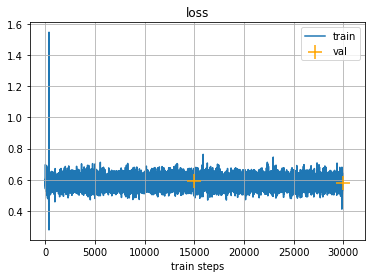

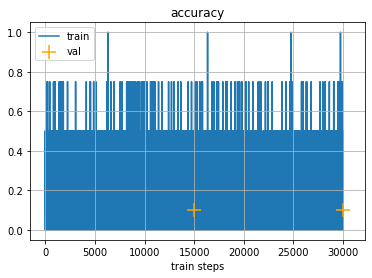

Train loss: 0.5826021093209585
Train acc: 0.10281666666666667
Val loss: 0.5816656527519226
Val acc: 0.1


KeyboardInterrupt: 

In [48]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.05, momentum=0.9)
train(model_2, criterion, optimizer, train_dataloader, eval_dataloader)